In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import scipy.stats as ss

In [4]:
import sklearn.preprocessing as pp

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import math
from collections import Counter

In [77]:
from sklearn.tree import DecisionTreeClassifier

In [7]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [8]:
#Reading the CSV file
df = pd.read_csv('mushrooms.csv')

In [9]:
#Checking the head of the dataframe
df.head()

class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  
0           o         p                 k          s       u  
1           o         p                 n          n       g  
2           o         p                 n          n       m  
3           o         p                 k          s       u  
4           o         e                 n          a       g  

[5 rows x 23 columns]

In [12]:
#Checking the shape of the dataframe
df.shape

(8124, 23)

In [13]:
#Checking the null values
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [15]:
column_names = df.columns

In [25]:
#print all the classes, number of distinct values and all the classes
for name in column_names:
    print(f"{name}: {df[name].nunique()} distinct values - {df[name].unique()}")

class: 2 distinct values - ['p' 'e']
cap-shape: 6 distinct values - ['x' 'b' 's' 'f' 'k' 'c']
cap-surface: 4 distinct values - ['s' 'y' 'f' 'g']
cap-color: 10 distinct values - ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises: 2 distinct values - ['t' 'f']
odor: 9 distinct values - ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment: 2 distinct values - ['f' 'a']
gill-spacing: 2 distinct values - ['c' 'w']
gill-size: 2 distinct values - ['n' 'b']
gill-color: 12 distinct values - ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape: 2 distinct values - ['e' 't']
stalk-root: 5 distinct values - ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring: 4 distinct values - ['s' 'f' 'k' 'y']
stalk-surface-below-ring: 4 distinct values - ['s' 'f' 'y' 'k']
stalk-color-above-ring: 9 distinct values - ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring: 9 distinct values - ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type: 1 distinct values - ['p']
veil-color: 4 distinct values - ['w' 

In [26]:
#Dropping the 'veil-type' since it only has 1 class and it won't help us
df.drop('veil-type',axis=1,inplace=True)

In [28]:
#checking for duplicates in rows
print(f"Known mushrooms: {len(df.index)} \n Unique mushrooms: {len(df.drop_duplicates().index)}")

Known mushrooms: 8124 
 Unique mushrooms: 8124


In [32]:
#checking if there are rows that have the same features but different classes ==> sanity check
df_features = df.drop('class',axis=1)
print(f"Known mushrooms: {len(df.index)} \nMushrooms with the same features: {len(df_features.drop_duplicates().index)}")

Known mushrooms: 8124 
Mushrooms with the same features: 8124


In [33]:
# Time to start diving deeper into the data. Let's see if there's a feature that can a better notion about 
# the mushromm's class. More formealy, we want to know if there's a certain feature that maximizes the information 
# about the class. For this, we will use Theil's U, also known as the Uncertainty Coefficient. Formaly marked as U(x|y), 
# this coefficient provides a value in the range of [0,1], where 0 means that feature y provides no information about 
# feature x, and 1 means that feature y provides full information abpout features x's value.

#code below was copied from: "https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival"

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [34]:
theilu = pd.DataFrame(index=['class'],columns=df.columns)

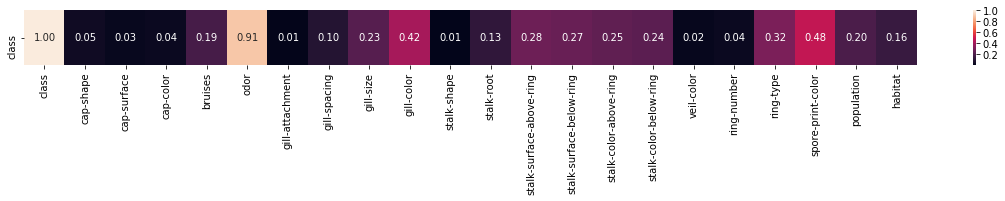

In [36]:
columns = df.columns
for j in range(0,len(columns)):
    u = theil_u(df['class'].tolist(),df[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')

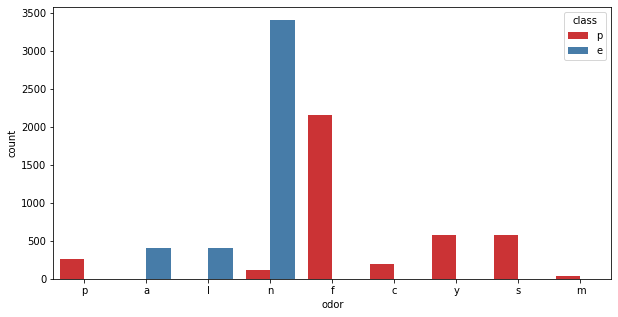

In [43]:
plt.figure(figsize=(10,5))
sns.countplot(x='odor',hue='class',data=df,palette="Set1")

In [44]:
#in the plot above, we can tell that if a mushroom is ediable or not just by smelling it.
# But what about all those mushrooms with no odor (odor='n')? Let's do the same trick again, but this time 
# only for the data of these mushrooms:

In [45]:
df_odorless = df[df['odor']=='n']

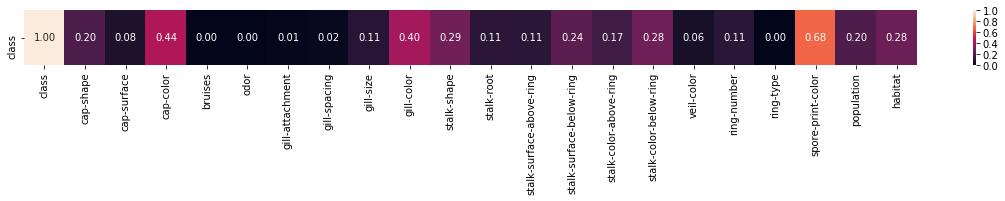

In [47]:
columns = df.columns
for j in range(0,len(columns)):
    u = theil_u(df_odorless['class'].tolist(),df_odorless[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')

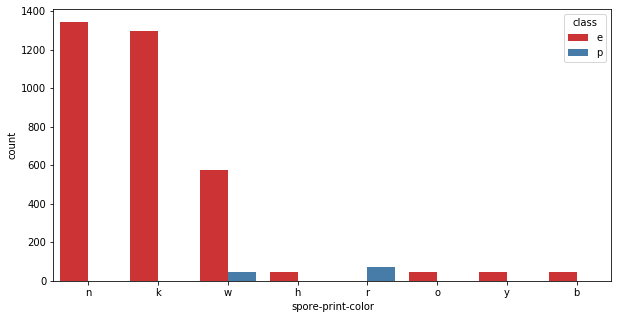

In [62]:
# Now the spore-print-color seems like a helpful feature:

plt.figure(figsize=(10,5))
sns.countplot(x='spore-print-color',hue='class',data=df_odorless,palette="Set1")

In [58]:
# Great success! We can tell odorless mushrooms apart by their spore color - unless it's white, then it's still ambiguous.
# Let's see how many mushrooms are we already able telling if they're ediable or not:
    
(len(df)-len(df[(df['odor']=='n') & (df['spore-print-color']=='w')]))/(len(df))*100

92.31905465288035

In [ ]:
So we can now determine the class of 92% of the mushrooms we know of.

Let's summarize our findings:

if the mushroom smells like almond (a) or anise (l), it's ediable.
if it has no odor, check its spore color - if it's not green (r), it's ediable. If it's white, we're not sure.
A little ML to speed things up:
We can keep going like this, but 92% percent classified mushroom is enough to help you find some food in the woods - 
and you only to remeber two things.

For the remaining 8%, let's use a Decision Tree (well, you are in the forest, aren't you?). The tree will pretty mush 
do what we did so far - ask the right questions to slice the data in the best way for classifications. 
Let's see how many branches it needs to get to perfect classification. For this, we'll need to factorize the remaining data
and use one-hot encoding.

In [63]:
df_odorless_white = df_odorless[df_odorless['spore-print-color']=='w']

In [64]:
len(df_odorless_white)

624

In [65]:
df_odorless_white.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 3984 to 8111
Data columns (total 22 columns):
class                       624 non-null object
cap-shape                   624 non-null object
cap-surface                 624 non-null object
cap-color                   624 non-null object
bruises                     624 non-null object
odor                        624 non-null object
gill-attachment             624 non-null object
gill-spacing                624 non-null object
gill-size                   624 non-null object
gill-color                  624 non-null object
stalk-shape                 624 non-null object
stalk-root                  624 non-null object
stalk-surface-above-ring    624 non-null object
stalk-surface-below-ring    624 non-null object
stalk-color-above-ring      624 non-null object
stalk-color-below-ring      624 non-null object
veil-color                  624 non-null object
ring-number                 624 non-null object
ring-type                  

In [66]:
for column in df_odorless_white.columns.values:
    f, _ = pd.factorize(df_odorless_white[column])
    df_odorless_white.loc[:,column] = f

C:\Users\shaya\Anaconda3\lib\site-packages\pandas\core\indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\shaya\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [68]:
df_odorless_white.head()

class  cap-shape  cap-surface  cap-color  bruises  odor  \
3984      0          0            0          0        0     0   
4165      0          1            1          1        1     0   
4276      0          2            0          2        1     0   
4283      0          1            2          3        0     0   
4291      0          2            2          3        0     0   

      gill-attachment  gill-spacing  gill-size  gill-color  ...  \
3984                0             0          0           0  ...   
4165                0             1          1           1  ...   
4276                0             1          1           1  ...   
4283                0             0          0           0  ...   
4291                0             0          0           0  ...   

      stalk-surface-above-ring  stalk-surface-below-ring  \
3984                         0                         0   
4165                         1                         1   
4276                         1                         1   
4283                         0                         0   
4291                         0                         0   

      stalk-color-above-ring  stalk-color-below-ring  veil-color  ring-number  \
3984                       0                       0           0            0   
4165                       1                       1           0            1   
4276                       1                       1           0            1   
4283                       1                       0           0            0   
4291                       1                       2           0            0   

      ring-type  spore-print-color  population  habitat  
3984          0                  0           0        0  
4165          0                  0           1        1  
4276          0                  0           1        1  
4283          0                  0           0        0  
4291          0                  0           0        0  

[5 rows x 22 columns]

In [118]:
df_odorless_white['stalk-color-below-ring'].value_counts()

0    424
2     96
1     80
3     24
Name: stalk-color-below-ring, dtype: int64

In [106]:
X = df_odorless_white.drop(['class'],axis=1)
y = df_odorless_white['class']
ohe = pp.OneHotEncoder()
ohe.fit(X)
X = ohe.transform(X).toarray()

C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [108]:
for i in range(1,6):
    tree = DecisionTreeClassifier(max_depth=i, random_state=42)
    tree.fit(X_train,y_train)
    y_pred = tree.predict(X_test)
    print("Max depth: {} - accuracy:".format(i), accuracy_score(y_test, y_pred, normalize=True))

Max depth: 1 - accuracy: 0.967948717948718
Max depth: 2 - accuracy: 0.9871794871794872
Max depth: 3 - accuracy: 0.9935897435897436
Max depth: 4 - accuracy: 0.9935897435897436
Max depth: 5 - accuracy: 1.0


In [109]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       291
           1       1.00      1.00      1.00        21

    accuracy                           1.00       312
   macro avg       1.00      1.00      1.00       312
weighted avg       1.00      1.00      1.00       312



In [110]:
print(confusion_matrix(y_test,y_pred))

[[291   0]
 [  0  21]]


In [ ]:
# Amazing! We got it all classified.

In [69]:
df_odorless_white_2 = df_odorless[df_odorless['spore-print-color']=='w']

In [71]:
list(df_odorless_white_2.columns)

['class',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'bruises',
 'odor',
 'gill-attachment',
 'gill-spacing',
 'gill-size',
 'gill-color',
 'stalk-shape',
 'stalk-root',
 'stalk-surface-above-ring',
 'stalk-surface-below-ring',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'veil-color',
 'ring-number',
 'ring-type',
 'spore-print-color',
 'population',
 'habitat']

In [72]:
for column in list(df_odorless_white_2.columns):
    Column = pd.get_dummies(df_odorless_white_2[column],drop_first=True)
    df_odorless_white_2.drop([column],axis=1,inplace=True)
    df_odorless_white_2 = pd.concat([df_odorless_white_2,Column],axis=1)

C:\Users\shaya\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [73]:
df_odorless_white_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 3984 to 8111
Data columns (total 47 columns):
p    624 non-null uint8
c    624 non-null uint8
f    624 non-null uint8
k    624 non-null uint8
x    624 non-null uint8
g    624 non-null uint8
s    624 non-null uint8
y    624 non-null uint8
c    624 non-null uint8
e    624 non-null uint8
g    624 non-null uint8
n    624 non-null uint8
p    624 non-null uint8
w    624 non-null uint8
y    624 non-null uint8
t    624 non-null uint8
w    624 non-null uint8
n    624 non-null uint8
g    624 non-null uint8
p    624 non-null uint8
w    624 non-null uint8
y    624 non-null uint8
b    624 non-null uint8
c    624 non-null uint8
k    624 non-null uint8
s    624 non-null uint8
y    624 non-null uint8
k    624 non-null uint8
s    624 non-null uint8
y    624 non-null uint8
n    624 non-null uint8
w    624 non-null uint8
y    624 non-null uint8
n    624 non-null uint8
w    624 non-null uint8
y    624 non-null uint8
y    624 non-null uint8
t  

In [74]:
df_odorless_white_2.head()

p  c  f  k  x  g  s  y  c  e  ...  t  p  n  s  v  y  g  l  p  w
3984  0  0  0  0  1  0  0  1  0  0  ...  1  0  0  0  0  0  0  0  0  1
4165  0  0  1  0  0  0  0  0  1  0  ...  0  0  0  0  1  0  0  1  0  0
4276  0  0  0  1  0  0  0  1  0  0  ...  0  0  0  0  1  0  0  1  0  0
4283  0  0  1  0  0  0  1  0  0  0  ...  1  0  0  0  0  0  0  0  0  1
4291  0  0  0  1  0  0  1  0  0  0  ...  1  0  0  0  0  0  0  0  0  1

[5 rows x 47 columns]

In [75]:
X = df_odorless_white_2.drop(['p'],axis=1)
y = df_odorless_white_2['p']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
for i in range(1,100):
    tree = DecisionTreeClassifier(max_depth=i, random_state=42)
    tree.fit(X_train,y_train)
    y_pred = tree.predict(X_test)
    print("Max depth: {} - accuracy:".format(i), accuracy_score(y_test, y_pred, normalize=True))

Max depth: 1 - accuracy: 0.656
Max depth: 2 - accuracy: 0.6
Max depth: 3 - accuracy: 0.84
Max depth: 4 - accuracy: 0.856
Max depth: 5 - accuracy: 0.84
Max depth: 6 - accuracy: 0.856
Max depth: 7 - accuracy: 0.864
Max depth: 8 - accuracy: 0.856
Max depth: 9 - accuracy: 0.848
Max depth: 10 - accuracy: 0.848
Max depth: 11 - accuracy: 0.84
Max depth: 12 - accuracy: 0.824
Max depth: 13 - accuracy: 0.824
Max depth: 14 - accuracy: 0.824
Max depth: 15 - accuracy: 0.824
Max depth: 16 - accuracy: 0.824
Max depth: 17 - accuracy: 0.824
Max depth: 18 - accuracy: 0.824
Max depth: 19 - accuracy: 0.824
Max depth: 20 - accuracy: 0.824
Max depth: 21 - accuracy: 0.824
Max depth: 22 - accuracy: 0.824
Max depth: 23 - accuracy: 0.824
Max depth: 24 - accuracy: 0.824
Max depth: 25 - accuracy: 0.824
Max depth: 26 - accuracy: 0.824
Max depth: 27 - accuracy: 0.824
Max depth: 28 - accuracy: 0.824
Max depth: 29 - accuracy: 0.824
Max depth: 30 - accuracy: 0.824
Max depth: 31 - accuracy: 0.824
Max depth: 32 - accura

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
for i in range(1,100):
    rf = RandomForestClassifier(max_depth=i, random_state=42)
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    print("Max depth: {} - accuracy:".format(i), accuracy_score(y_test, y_pred, normalize=True))

C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Max depth: 1 - accuracy: 0.576
Max depth: 2 - accuracy: 0.656
Max depth: 3 - accuracy: 0.72
Max depth: 4 - accuracy: 0.8
Max depth: 5 - accuracy: 0.864
Max depth: 6 - accuracy: 0.864
Max depth: 7 - accuracy: 0.856
Max depth: 8 - accuracy: 0.832
Max depth: 9 - accuracy: 0.824
Max depth: 10 - accuracy: 0.816
Max depth: 11 - accuracy: 0.832
Max depth: 12 - accuracy: 0.816


C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Max depth: 13 - accuracy: 0.824
Max depth: 14 - accuracy: 0.824
Max depth: 15 - accuracy: 0.824
Max depth: 16 - accuracy: 0.824
Max depth: 17 - accuracy: 0.824
Max depth: 18 - accuracy: 0.824
Max depth: 19 - accuracy: 0.824
Max depth: 20 - accuracy: 0.824
Max depth: 21 - accuracy: 0.824
Max depth: 22 - accuracy: 0.824
Max depth: 23 - accuracy: 0.824
Max depth: 24 - accuracy: 0.824


C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Max depth: 25 - accuracy: 0.824
Max depth: 26 - accuracy: 0.824
Max depth: 27 - accuracy: 0.824
Max depth: 28 - accuracy: 0.824
Max depth: 29 - accuracy: 0.824
Max depth: 30 - accuracy: 0.824
Max depth: 31 - accuracy: 0.824
Max depth: 32 - accuracy: 0.824
Max depth: 33 - accuracy: 0.824
Max depth: 34 - accuracy: 0.824
Max depth: 35 - accuracy: 0.824


C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Max depth: 36 - accuracy: 0.824
Max depth: 37 - accuracy: 0.824
Max depth: 38 - accuracy: 0.824
Max depth: 39 - accuracy: 0.824
Max depth: 40 - accuracy: 0.824
Max depth: 41 - accuracy: 0.824
Max depth: 42 - accuracy: 0.824
Max depth: 43 - accuracy: 0.824
Max depth: 44 - accuracy: 0.824
Max depth: 45 - accuracy: 0.824
Max depth: 46 - accuracy: 0.824


C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Max depth: 47 - accuracy: 0.824
Max depth: 48 - accuracy: 0.824
Max depth: 49 - accuracy: 0.824
Max depth: 50 - accuracy: 0.824
Max depth: 51 - accuracy: 0.824
Max depth: 52 - accuracy: 0.824
Max depth: 53 - accuracy: 0.824
Max depth: 54 - accuracy: 0.824
Max depth: 55 - accuracy: 0.824
Max depth: 56 - accuracy:

C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

 0.824
Max depth: 57 - accuracy: 0.824
Max depth: 58 - accuracy: 0.824
Max depth: 59 - accuracy: 0.824
Max depth: 60 - accuracy: 0.824
Max depth: 61 - accuracy: 0.824
Max depth: 62 - accuracy: 0.824
Max depth: 63 - accuracy: 0.824
Max depth: 64 - accuracy: 0.824
Max depth: 65 - accuracy: 0.824
Max depth: 66 - accuracy: 0.824


C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Max depth: 67 - accuracy: 0.824
Max depth: 68 - accuracy: 0.824
Max depth: 69 - accuracy: 0.824
Max depth: 70 - accuracy: 0.824
Max depth: 71 - accuracy: 0.824
Max depth: 72 - accuracy: 0.824
Max depth: 73 - accuracy: 0.824
Max depth: 74 - accuracy: 0.824
Max depth: 75 - accuracy: 0.824
Max depth: 76 - accuracy: 0.824
Max depth: 77 - accuracy: 0.824


C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Max depth: 78 - accuracy: 0.824
Max depth: 79 - accuracy: 0.824
Max depth: 80 - accuracy: 0.824
Max depth: 81 - accuracy: 0.824
Max depth: 82 - accuracy: 0.824
Max depth: 83 - accuracy: 0.824
Max depth: 84 - accuracy: 0.824
Max depth: 85 - accuracy: 0.824
Max depth: 86 - accuracy: 0.824
Max depth: 87 - accuracy: 0.824
Max depth: 88 - accuracy: 0.824
Max depth: 89 - accuracy: 0.824


C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\shaya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Max depth: 90 - accuracy: 0.824
Max depth: 91 - accuracy: 0.824
Max depth: 92 - accuracy: 0.824
Max depth: 93 - accuracy: 0.824
Max depth: 94 - accuracy: 0.824
Max depth: 95 - accuracy: 0.824
Max depth: 96 - accuracy: 0.824
Max depth: 97 - accuracy: 0.824
Max depth: 98 - accuracy: 0.824
Max depth: 99 - accuracy: 0.824
